In [1]:
!pip install torch torchvision einops timm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


# ViT-MAE

Tham khảo code từ https://github.com/IcarusWizard/MAE/blob/main/model.py

# IMPORT THƯ VIỆN

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from timm.models.vision_transformer import Block
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from timm.models.layers import trunc_normal_

In [3]:
# Hàm tạo chỉ số ngẫu nhiên và chỉ số ngược lại
def random_indexes(size: int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

# Hàm lấy các phần tử theo chỉ số
def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

# LOAD DỮ LIỆU

In [4]:
# Collect labels from the training and validation directories
labels_list = []
train_dir = '/kaggle/input/vn-moto-dataset'
val_dir = '/kaggle/input/tiny-moto-dataset'

In [5]:
# Function to collect labels while preserving order and avoiding duplicates
def collect_labels(dir_path, labels_list):
    for subfolder in os.listdir(dir_path):
        if not subfolder.endswith('.txt') and subfolder not in labels_list:
            labels_list.append(subfolder)

In [6]:
# Collect labels from both directories
collect_labels(train_dir, labels_list)
collect_labels(val_dir, labels_list)

In [7]:
# Create a mapping from label names to indices
label_to_idx = {label: idx for idx, label in enumerate(labels_list)}

In [8]:
train_images_labels = []
for subfolder in os.listdir(train_dir):
    if not subfolder.endswith('.txt'):
        label_idx = label_to_idx[subfolder]
        subfolder_path = os.path.join(train_dir, subfolder)
        for file in os.listdir(subfolder_path):
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(subfolder_path, file)
                train_images_labels.append((image_path, label_idx))

In [9]:
# Prepare the validation data with labels
val_images_labels = []
for subfolder in os.listdir(val_dir):
    if not subfolder.endswith('.txt'):
        label_idx = label_to_idx[subfolder]
        subfolder_path = os.path.join(val_dir, subfolder)
        for file in os.listdir(subfolder_path):
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(subfolder_path, file)
                val_images_labels.append((image_path, label_idx))

In [10]:
# Define the custom dataset class
class MyDataset(Dataset):
    def __init__(self, images_labels, transform=None):
        self.images_labels = images_labels
        self.transform = transform
        self.valid_images_labels = []
        for path, label in self.images_labels:
            try:
                img = Image.open(path)
                if img.mode != "P":  # Exclude palette mode images
                    self.valid_images_labels.append((path, label))
            except Exception as e:
                print(f"Error loading image {path}: {e}")

    def __len__(self):
        return len(self.valid_images_labels)

    def __getitem__(self, index):
        path, label = self.valid_images_labels[index]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [11]:
# Define image transformations
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Create dataset and dataloader instances
train_dataset = MyDataset(train_images_labels, train_transform)
val_dataset = MyDataset(val_images_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=4)

# Định nghĩa các lớp MAE

In [12]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches: torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

In [13]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, emb_dim=192, num_layer=12, num_head=3, mask_ratio=0.75) -> None:
        super().__init__()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        
        # Tính số lượng patch từ image_size và patch_size
        num_patches = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.zeros(num_patches, 1, emb_dim))  # Positional embedding cho các patch
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)  # Chia ảnh thành patch
        patches = rearrange(patches, 'b c h w -> (h w) b c')  # Reshape thành (num_patches, batch_size, emb_dim)
        
        # Kiểm tra kích thước patches và pos_embedding
        assert patches.shape[0] == self.pos_embedding.shape[0], (
            f"Mismatch: patches {patches.shape[0]} vs pos_embedding {self.pos_embedding.shape[0]}"
        )
        
        patches = patches + self.pos_embedding  # Thêm positional embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

In [14]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, emb_dim=192, num_layer=4, num_head=3) -> None:
        super().__init__()

        self.mask_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        num_patches = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.zeros(num_patches + 1, 1, emb_dim))  # +1 cho CLS token

        self.transformer = nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', 
                                   p1=patch_size, p2=patch_size, h=image_size // patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:]  # Remove CLS token

        patches = self.head(features)
        img = self.patch2img(patches)

        return img

In [15]:
class MAE_ViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, emb_dim=192, encoder_layer=12, encoder_head=6, decoder_layer=4, decoder_head=6, mask_ratio=0.75) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img = self.decoder(features, backward_indexes)
        return predicted_img

In [16]:
from tqdm import tqdm

def train_one_epoch(model, optimizer, criterion, data_loader, device, epoch):
    model.train()
    total_loss = 0

    # Hiển thị thanh tiến trình với tqdm
    data_loader = tqdm(data_loader, desc=f"[Epoch {epoch}]")
    
    for step, (img, _) in enumerate(data_loader):
        img = img.to(device)
        optimizer.zero_grad()

        predicted_img = model(img)
        loss = criterion(predicted_img, img)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Cập nhật thanh tiến trình
        data_loader.set_postfix({"loss": total_loss / (step + 1)})

    avg_loss = total_loss / len(data_loader)
    print(f"[Epoch {epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss


# Khởi tạo mô hình MAE

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MAE_ViT(image_size=224, patch_size=16, emb_dim=192, encoder_layer=12, encoder_head=6, decoder_layer=4, decoder_head=6, mask_ratio=0.75).to(device)

In [18]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                        Param #
MAE_ViT                                       --
├─MAE_Encoder: 1-1                            37,824
│    └─PatchShuffle: 2-1                      --
│    └─Conv2d: 2-2                            147,648
│    └─Sequential: 2-3                        --
│    │    └─Block: 3-1                        444,288
│    │    └─Block: 3-2                        444,288
│    │    └─Block: 3-3                        444,288
│    │    └─Block: 3-4                        444,288
│    │    └─Block: 3-5                        444,288
│    │    └─Block: 3-6                        444,288
│    │    └─Block: 3-7                        444,288
│    │    └─Block: 3-8                        444,288
│    │    └─Block: 3-9                        444,288
│    │    └─Block: 3-10                       444,288
│    │    └─Block: 3-11                       444,288
│    │    └─Block: 3-12                       444,288
│    └─LayerNorm: 2-4                       

# HUẤN LUYỆN MÔ HÌNH MAE

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()

In [20]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device, epoch)


[Epoch 1]: 100%|██████████| 476/476 [01:21<00:00,  5.83it/s, loss=0.989]


[Epoch 1] Average Loss: 0.9886


[Epoch 2]: 100%|██████████| 476/476 [01:21<00:00,  5.86it/s, loss=0.89]


[Epoch 2] Average Loss: 0.8903


[Epoch 3]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.818]


[Epoch 3] Average Loss: 0.8181


[Epoch 4]: 100%|██████████| 476/476 [01:21<00:00,  5.87it/s, loss=0.659]


[Epoch 4] Average Loss: 0.6593


[Epoch 5]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.591]


[Epoch 5] Average Loss: 0.5906


[Epoch 6]: 100%|██████████| 476/476 [01:21<00:00,  5.82it/s, loss=0.564]


[Epoch 6] Average Loss: 0.5639


[Epoch 7]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.545]


[Epoch 7] Average Loss: 0.5450


[Epoch 8]: 100%|██████████| 476/476 [01:22<00:00,  5.79it/s, loss=0.526]


[Epoch 8] Average Loss: 0.5261


[Epoch 9]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.505]


[Epoch 9] Average Loss: 0.5047


[Epoch 10]: 100%|██████████| 476/476 [01:21<00:00,  5.84it/s, loss=0.485]


[Epoch 10] Average Loss: 0.4850


[Epoch 11]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.469]


[Epoch 11] Average Loss: 0.4687


[Epoch 12]: 100%|██████████| 476/476 [01:23<00:00,  5.70it/s, loss=0.455]


[Epoch 12] Average Loss: 0.4553


[Epoch 13]: 100%|██████████| 476/476 [01:22<00:00,  5.80it/s, loss=0.445]


[Epoch 13] Average Loss: 0.4450


[Epoch 14]: 100%|██████████| 476/476 [01:21<00:00,  5.82it/s, loss=0.437]


[Epoch 14] Average Loss: 0.4369


[Epoch 15]: 100%|██████████| 476/476 [01:21<00:00,  5.83it/s, loss=0.43]


[Epoch 15] Average Loss: 0.4302


[Epoch 16]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.425]


[Epoch 16] Average Loss: 0.4251


[Epoch 17]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.42]


[Epoch 17] Average Loss: 0.4204


[Epoch 18]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.416]


[Epoch 18] Average Loss: 0.4161


[Epoch 19]: 100%|██████████| 476/476 [01:21<00:00,  5.82it/s, loss=0.412]


[Epoch 19] Average Loss: 0.4122


[Epoch 20]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.41]


[Epoch 20] Average Loss: 0.4096


[Epoch 21]: 100%|██████████| 476/476 [01:22<00:00,  5.79it/s, loss=0.406]


[Epoch 21] Average Loss: 0.4064


[Epoch 22]: 100%|██████████| 476/476 [01:22<00:00,  5.78it/s, loss=0.404]


[Epoch 22] Average Loss: 0.4036


[Epoch 23]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.401]


[Epoch 23] Average Loss: 0.4011


[Epoch 24]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.399]


[Epoch 24] Average Loss: 0.3989


[Epoch 25]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.396]


[Epoch 25] Average Loss: 0.3956


[Epoch 26]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.394]


[Epoch 26] Average Loss: 0.3945


[Epoch 27]: 100%|██████████| 476/476 [01:24<00:00,  5.66it/s, loss=0.392]


[Epoch 27] Average Loss: 0.3924


[Epoch 28]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.39]


[Epoch 28] Average Loss: 0.3903


[Epoch 29]: 100%|██████████| 476/476 [01:23<00:00,  5.73it/s, loss=0.389]


[Epoch 29] Average Loss: 0.3888


[Epoch 30]: 100%|██████████| 476/476 [01:23<00:00,  5.70it/s, loss=0.386]


[Epoch 30] Average Loss: 0.3864


[Epoch 31]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.385]


[Epoch 31] Average Loss: 0.3852


[Epoch 32]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.384]


[Epoch 32] Average Loss: 0.3838


[Epoch 33]: 100%|██████████| 476/476 [01:22<00:00,  5.75it/s, loss=0.383]


[Epoch 33] Average Loss: 0.3826


[Epoch 34]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.381]


[Epoch 34] Average Loss: 0.3809


[Epoch 35]: 100%|██████████| 476/476 [01:22<00:00,  5.78it/s, loss=0.38]


[Epoch 35] Average Loss: 0.3800


[Epoch 36]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.378]


[Epoch 36] Average Loss: 0.3781


[Epoch 37]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.377]


[Epoch 37] Average Loss: 0.3767


[Epoch 38]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.376]


[Epoch 38] Average Loss: 0.3759


[Epoch 39]: 100%|██████████| 476/476 [01:22<00:00,  5.74it/s, loss=0.375]


[Epoch 39] Average Loss: 0.3746


[Epoch 40]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.373]


[Epoch 40] Average Loss: 0.3731


[Epoch 41]: 100%|██████████| 476/476 [01:23<00:00,  5.68it/s, loss=0.372]


[Epoch 41] Average Loss: 0.3725


[Epoch 42]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.371]


[Epoch 42] Average Loss: 0.3708


[Epoch 43]: 100%|██████████| 476/476 [01:22<00:00,  5.77it/s, loss=0.371]


[Epoch 43] Average Loss: 0.3712


[Epoch 44]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.37]


[Epoch 44] Average Loss: 0.3703


[Epoch 45]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.369]


[Epoch 45] Average Loss: 0.3687


[Epoch 46]: 100%|██████████| 476/476 [01:23<00:00,  5.70it/s, loss=0.368]


[Epoch 46] Average Loss: 0.3675


[Epoch 47]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.367]


[Epoch 47] Average Loss: 0.3673


[Epoch 48]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.366]


[Epoch 48] Average Loss: 0.3658


[Epoch 49]: 100%|██████████| 476/476 [01:22<00:00,  5.79it/s, loss=0.365]


[Epoch 49] Average Loss: 0.3655


[Epoch 50]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.364]


[Epoch 50] Average Loss: 0.3637


[Epoch 51]: 100%|██████████| 476/476 [01:22<00:00,  5.78it/s, loss=0.363]


[Epoch 51] Average Loss: 0.3631


[Epoch 52]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.363]


[Epoch 52] Average Loss: 0.3630


[Epoch 53]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.362]


[Epoch 53] Average Loss: 0.3619


[Epoch 54]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.361]


[Epoch 54] Average Loss: 0.3611


[Epoch 55]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.361]


[Epoch 55] Average Loss: 0.3610


[Epoch 56]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.36]


[Epoch 56] Average Loss: 0.3600


[Epoch 57]: 100%|██████████| 476/476 [01:23<00:00,  5.67it/s, loss=0.359]


[Epoch 57] Average Loss: 0.3588


[Epoch 58]: 100%|██████████| 476/476 [01:24<00:00,  5.64it/s, loss=0.359]


[Epoch 58] Average Loss: 0.3588


[Epoch 59]: 100%|██████████| 476/476 [01:24<00:00,  5.61it/s, loss=0.358]


[Epoch 59] Average Loss: 0.3581


[Epoch 60]: 100%|██████████| 476/476 [01:24<00:00,  5.66it/s, loss=0.357]


[Epoch 60] Average Loss: 0.3571


[Epoch 61]: 100%|██████████| 476/476 [01:24<00:00,  5.60it/s, loss=0.357]


[Epoch 61] Average Loss: 0.3566


[Epoch 62]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.355]


[Epoch 62] Average Loss: 0.3555


[Epoch 63]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.356]


[Epoch 63] Average Loss: 0.3555


[Epoch 64]: 100%|██████████| 476/476 [01:24<00:00,  5.65it/s, loss=0.355]


[Epoch 64] Average Loss: 0.3553


[Epoch 65]: 100%|██████████| 476/476 [01:24<00:00,  5.66it/s, loss=0.354]


[Epoch 65] Average Loss: 0.3542


[Epoch 66]: 100%|██████████| 476/476 [01:23<00:00,  5.68it/s, loss=0.354]


[Epoch 66] Average Loss: 0.3539


[Epoch 67]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.353]


[Epoch 67] Average Loss: 0.3529


[Epoch 68]: 100%|██████████| 476/476 [01:22<00:00,  5.74it/s, loss=0.352]


[Epoch 68] Average Loss: 0.3521


[Epoch 69]: 100%|██████████| 476/476 [01:24<00:00,  5.63it/s, loss=0.352]


[Epoch 69] Average Loss: 0.3519


[Epoch 70]: 100%|██████████| 476/476 [01:22<00:00,  5.76it/s, loss=0.351]


[Epoch 70] Average Loss: 0.3513


[Epoch 71]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.351]


[Epoch 71] Average Loss: 0.3512


[Epoch 72]: 100%|██████████| 476/476 [01:23<00:00,  5.70it/s, loss=0.35]


[Epoch 72] Average Loss: 0.3503


[Epoch 73]: 100%|██████████| 476/476 [01:21<00:00,  5.82it/s, loss=0.35]


[Epoch 73] Average Loss: 0.3496


[Epoch 74]: 100%|██████████| 476/476 [01:23<00:00,  5.71it/s, loss=0.35]


[Epoch 74] Average Loss: 0.3496


[Epoch 75]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.349]


[Epoch 75] Average Loss: 0.3489


[Epoch 76]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.349]


[Epoch 76] Average Loss: 0.3485


[Epoch 77]: 100%|██████████| 476/476 [01:24<00:00,  5.61it/s, loss=0.348]


[Epoch 77] Average Loss: 0.3478


[Epoch 78]: 100%|██████████| 476/476 [01:24<00:00,  5.61it/s, loss=0.347]


[Epoch 78] Average Loss: 0.3474


[Epoch 79]: 100%|██████████| 476/476 [01:24<00:00,  5.63it/s, loss=0.348]


[Epoch 79] Average Loss: 0.3476


[Epoch 80]: 100%|██████████| 476/476 [01:23<00:00,  5.68it/s, loss=0.347]


[Epoch 80] Average Loss: 0.3475


[Epoch 81]: 100%|██████████| 476/476 [01:24<00:00,  5.65it/s, loss=0.347]


[Epoch 81] Average Loss: 0.3471


[Epoch 82]: 100%|██████████| 476/476 [01:23<00:00,  5.68it/s, loss=0.346]


[Epoch 82] Average Loss: 0.3462


[Epoch 83]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.345]


[Epoch 83] Average Loss: 0.3454


[Epoch 84]: 100%|██████████| 476/476 [01:25<00:00,  5.55it/s, loss=0.346]


[Epoch 84] Average Loss: 0.3459


[Epoch 85]: 100%|██████████| 476/476 [01:24<00:00,  5.66it/s, loss=0.344]


[Epoch 85] Average Loss: 0.3444


[Epoch 86]: 100%|██████████| 476/476 [01:25<00:00,  5.59it/s, loss=0.345]


[Epoch 86] Average Loss: 0.3445


[Epoch 87]: 100%|██████████| 476/476 [01:24<00:00,  5.66it/s, loss=0.344]


[Epoch 87] Average Loss: 0.3442


[Epoch 88]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.344]


[Epoch 88] Average Loss: 0.3441


[Epoch 89]: 100%|██████████| 476/476 [01:24<00:00,  5.63it/s, loss=0.343]


[Epoch 89] Average Loss: 0.3434


[Epoch 90]: 100%|██████████| 476/476 [01:24<00:00,  5.63it/s, loss=0.343]


[Epoch 90] Average Loss: 0.3427


[Epoch 91]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.343]


[Epoch 91] Average Loss: 0.3426


[Epoch 92]: 100%|██████████| 476/476 [01:23<00:00,  5.69it/s, loss=0.342]


[Epoch 92] Average Loss: 0.3422


[Epoch 93]: 100%|██████████| 476/476 [01:23<00:00,  5.72it/s, loss=0.341]


[Epoch 93] Average Loss: 0.3414


[Epoch 94]: 100%|██████████| 476/476 [01:25<00:00,  5.56it/s, loss=0.341]


[Epoch 94] Average Loss: 0.3415


[Epoch 95]: 100%|██████████| 476/476 [01:24<00:00,  5.65it/s, loss=0.341]


[Epoch 95] Average Loss: 0.3409


[Epoch 96]: 100%|██████████| 476/476 [01:24<00:00,  5.61it/s, loss=0.34]


[Epoch 96] Average Loss: 0.3403


[Epoch 97]: 100%|██████████| 476/476 [01:25<00:00,  5.60it/s, loss=0.34]


[Epoch 97] Average Loss: 0.3402


[Epoch 98]: 100%|██████████| 476/476 [01:22<00:00,  5.74it/s, loss=0.34]


[Epoch 98] Average Loss: 0.3400


[Epoch 99]: 100%|██████████| 476/476 [01:24<00:00,  5.64it/s, loss=0.34]


[Epoch 99] Average Loss: 0.3400


[Epoch 100]: 100%|██████████| 476/476 [01:21<00:00,  5.81it/s, loss=0.339]

[Epoch 100] Average Loss: 0.3391


In [21]:
# for epoch in range(10):
#     model.train()
#     total_loss = 0
#     for img, label in train_loader:
#         img = img.to(device)
#         optimizer.zero_grad()
#         predicted_img = model(img)
#         loss = criterion(predicted_img, img)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

In [22]:
# # Lưu mô hình MAE sau khi huấn luyện
# torch.save(model.state_dict(), "mae_model.pth")
# print("Saved MAE model to 'mae_model.pth'.")

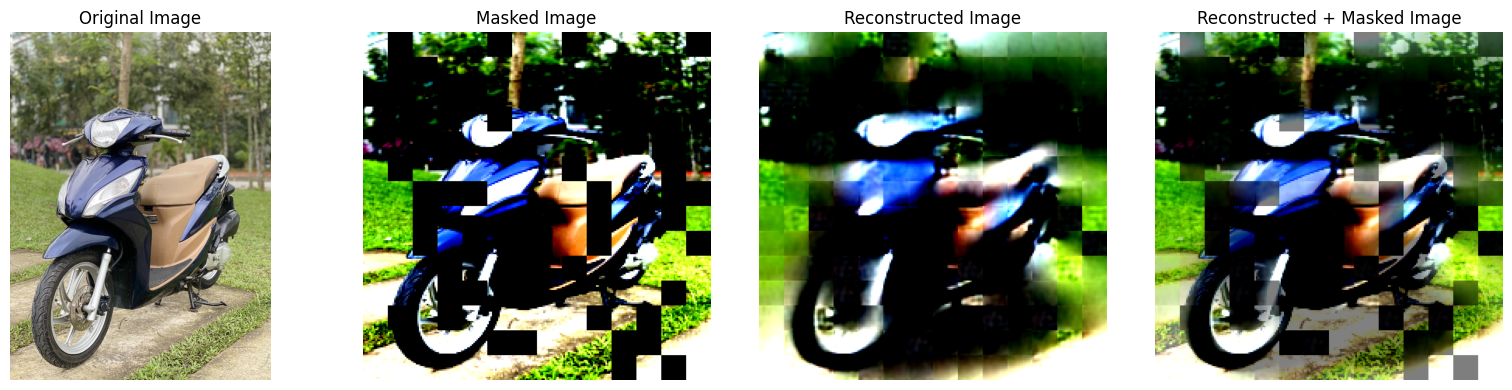

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from einops import rearrange

# Đọc ảnh từ đường dẫn
image_path = '/kaggle/input/vn-moto-dataset/Honda/17520255.Honda.20.jpg'
image = Image.open(image_path).convert("RGB")

# Biến đổi ảnh thành tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize để phù hợp với kích thước của model
    transforms.ToTensor(),  # Chuyển đổi thành tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize theo ImageNet
])
image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm một chiều cho batch_size

# Hàm tạo mask cho ảnh
def apply_mask(image, mask_ratio=0.75):
    """
    Áp dụng mask cho ảnh bằng cách làm mờ một phần tỷ lệ nhất định của các patch.
    """
    B, C, H, W = image.shape  # B: batch_size, C: channels, H: height, W: width
    ph, pw = 16, 16  # Kích thước patch (16x16)
    num_patches_h = H // ph
    num_patches_w = W // pw
    num_patches = num_patches_h * num_patches_w  # Tổng số patch từ ảnh

    mask = torch.ones(num_patches).to(image.device)  # Tạo một mask cho các patch

    # Số lượng patch cần che khuất
    num_masked_patches = int(num_patches * mask_ratio)
    
    # Chọn ngẫu nhiên các patch để mask (đặt giá trị của các patch đó là 0)
    mask[:num_masked_patches] = 0
    mask = mask[torch.randperm(len(mask))]  # Xáo trộn mask ngẫu nhiên

    # Chia ảnh thành các patch (B x num_patches x ph x pw)
    patches = rearrange(image, 'b c (h ph) (w pw) -> (b h w) c ph pw', ph=ph, pw=pw)
    masked_patches = patches.clone()

    # Làm mờ các patch được mask (set to 0)
    for i in range(mask.shape[0]):
        if mask[i] == 0:  # Nếu patch bị mask
            masked_patches[i] = 0

    # Tạo ảnh đã bị mask từ các patch
    masked_image = rearrange(masked_patches, '(b h w) c ph pw -> b c (h ph) (w pw)', h=num_patches_h, w=num_patches_w)

    return masked_image, mask

# Hàm dùng để lấy phần tử từ tensor theo chỉ số
def take_indexes(sequences, indexes):
    expanded_indexes = indexes.unsqueeze(-1).expand(-1, -1, sequences.shape[-1])
    return torch.gather(sequences, 0, expanded_indexes)

# Sử dụng mô hình MAE-ViT để tái tạo ảnh
model.eval()  # Đảm bảo model ở chế độ evaluation
with torch.no_grad():
    # Áp dụng mask cho ảnh
    masked_image, mask = apply_mask(image_tensor, mask_ratio=0.25)
    
    # Tái tạo ảnh từ các patch còn lại
    reconstructed_image = model(masked_image)  # Dự đoán ảnh tái tạo từ model

# Chuyển kết quả về dạng có thể hiển thị
masked_image = masked_image.squeeze(0).cpu().permute(1, 2, 0)
reconstructed_image = reconstructed_image.squeeze(0).cpu().permute(1, 2, 0)

# Hiển thị ảnh gốc, ảnh bị mask và ảnh tái tạo
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(masked_image)
axes[1].set_title("Masked Image")
axes[1].axis('off')

axes[2].imshow(reconstructed_image)
axes[2].set_title("Reconstructed Image")
axes[2].axis('off')

# Hiển thị ảnh tái tạo kết hợp với mask
axes[3].imshow(masked_image)
axes[3].imshow(reconstructed_image, alpha=0.5)  # Kết hợp mask và hồi phục với độ mờ
axes[3].set_title("Reconstructed + Masked Image")
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Fine-tune cho phân loại

In [24]:
class ViT_Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(encoder.cls_token.shape[-1], num_classes)

    def forward(self, img):
        features, _ = self.encoder(img)
        cls_token = features[0]
        logits = self.head(cls_token)
        return logits

In [25]:
num_classes = 5  # Số lượng lớp
classifier = ViT_Classifier(model.encoder, num_classes).to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

In [26]:
# weight_dict = torch.load('/kaggle/input/vit-mae-ver2/best_model.pth', map_location=device)

In [27]:
# classifier.load_state_dict(weight_dict, strict=False)

In [28]:
def classifier_train_one_epoch(classifier, optimizer_cls, criterion_cls, train_loader, device, epoch):
    classifier.train()
    total_loss, correct, total = 0, 0, 0
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optimizer_cls.zero_grad()
        logits = classifier(img)
        loss = criterion_cls(logits, label)
        loss.backward()
        optimizer_cls.step()
        total_loss += loss.item()
        correct += (logits.argmax(1) == label).sum().item()
        total += label.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [29]:
def classifier_val(classifier, criterion_cls, train_loader, device, epoch):
    classifier.eval()
    total_loss, correct, total = 0, 0, 0
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        with torch.no_grad():
            logits = classifier(img)
        loss = criterion_cls(logits, label)
        total_loss += loss.item()
        correct += (logits.argmax(1) == label).sum().item()
        total += label.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Val epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy
        

In [30]:
best_loss = 1e9
patience = 0
for epoch in range(10):
    # train
    train_loss, train_acc = classifier_train_one_epoch(classifier,optimizer_cls,criterion_cls,train_loader,device,epoch)

    # validate
    val_loss, val_acc = classifier_val(classifier,criterion_cls,val_loader,device,epoch)
    if best_loss > val_loss:
        torch.save(model.state_dict(), "best_model.pth")
        best_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience >= 3:
            print("Loss does not improve in 3 epochs. Early Stopping!")
            break

Epoch 1, Loss: 1.2498, Accuracy: 48.15%
Val epoch 1, Loss: 1.2366, Accuracy: 51.56%
Epoch 2, Loss: 1.1372, Accuracy: 53.93%
Val epoch 2, Loss: 1.2576, Accuracy: 48.11%
Epoch 3, Loss: 1.0969, Accuracy: 56.02%
Val epoch 3, Loss: 1.3239, Accuracy: 46.00%
Epoch 4, Loss: 1.0554, Accuracy: 57.66%
Val epoch 4, Loss: 1.2939, Accuracy: 42.89%
Loss does not improve in 3 epochs. Early Stopping!


In [31]:
# Lưu mô hình ViT classifier sau khi fine-tune
torch.save(classifier.state_dict(), "vit_classifier.pth")
print("Saved ViT classifier model to 'vit_classifier.pth'.")

Saved ViT classifier model to 'vit_classifier.pth'.


# Đánh giá mô hình

In [32]:
import torch

# Tải state_dict từ file
state_dict = torch.load("/kaggle/input/vit-mae-ver2/vit_classifier.pth")

/tmp/ipykernel_23/1485086059.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/vit-mae-ver2/vit_classifier.pth")


In [33]:
# Tính tổng số lượng tham số
total_params = sum(param.numel() for param in state_dict.values())

print(f"Tổng số lượng tham số: {total_params}")

Tổng số lượng tham số: 5518277
